# Adversarial Attacks on ResNet18

In [16]:
from pathlib import Path


import torch
from torch import nn
from torch.utils.data import DataLoader

from model.resnet_model import CNNClassifier
from ml_utils import CustomDataset

import matplotlib.pyplot as plt

### Load the dataset

In [17]:
train_dt = CustomDataset(data_path=Path("../datasets/car_dataset"), portion="test")
train_loader = DataLoader(train_dt, batch_size=2, shuffle=True, num_workers=4)

### Load the pretrained model

In [18]:
cls = CNNClassifier(num_classes=196, pretrained=True, model_name="resnet18", freeze_layers=0)
cls.load_state_dict(torch.load("../experiments/results/r18_pretrained_fre0.pth", weights_only=True))
cls.eval()

CNNClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Get a batch of data

In [19]:
dt_iter = iter(train_loader)
X, y = next(dt_iter)

In [21]:
X.requires_grad_(True)
logits = cls(X)
loss = nn.CrossEntropyLoss()(logits, y)
cls.zero_grad()
loss.backward()

In [22]:
y_prob = torch.softmax(logits, dim=1)
y_hat = torch.argmax(y_prob, dim=1)

In [23]:
print("Model confidence", [(y_prob[idx,i] * 100).item() for idx, i in enumerate(y_hat)])

Model confidence [88.50202178955078, 95.2286148071289]


In [24]:
adv_img = X + .007 * torch.sign(X.grad)
with torch.no_grad():
    adv_logits = cls(adv_img)
    adv_y_prob = torch.softmax(adv_logits, dim=1)
    adv_y_hat = torch.argmax(adv_y_prob, dim=1)

In [25]:
print("Model confidence", [(adv_y_prob[idx,i] * 100).item() for idx, i in enumerate(y_hat)])

Model confidence [0.7598013281822205, 0.12701399624347687]


In [37]:
X_plot = torch.clamp(X.detach(),0, 1).permute(0, 2, 3, 1)
perturbation_plot = torch.clamp(torch.sign(X.grad),0,1).permute(0, 2, 3, 1)
adv_plot = torch.clamp(adv_img.detach(), 0, 1).permute(0, 2, 3, 1)


top_labels = torch.argsort(-y_prob, dim=1)[:,:3]
row_indices = torch.arange(y_prob.shape[0]).unsqueeze(1).expand_as(top_labels)
top_dist = y_prob[row_indices,top_labels].detach()


adv_top_labels = torch.argsort(-adv_y_prob, dim=1)[:,:3]
adv_row_indices = torch.arange(adv_y_prob.shape[0]).unsqueeze(1).expand_as(adv_top_labels)
adv_top_dist = y_prob[adv_row_indices, adv_top_labels].detach()

all_dist_values = torch.concatenate([top_dist[0], top_dist[1], adv_top_dist[0], adv_top_dist[1]])
min_x = torch.min(all_dist_values[all_dist_values > 0]) # Evita log(0)
max_x = torch.max(all_dist_values)

margin = 0.2
min_x_log = min_x * (1 - margin)
max_x_log = max_x * (1 + margin)

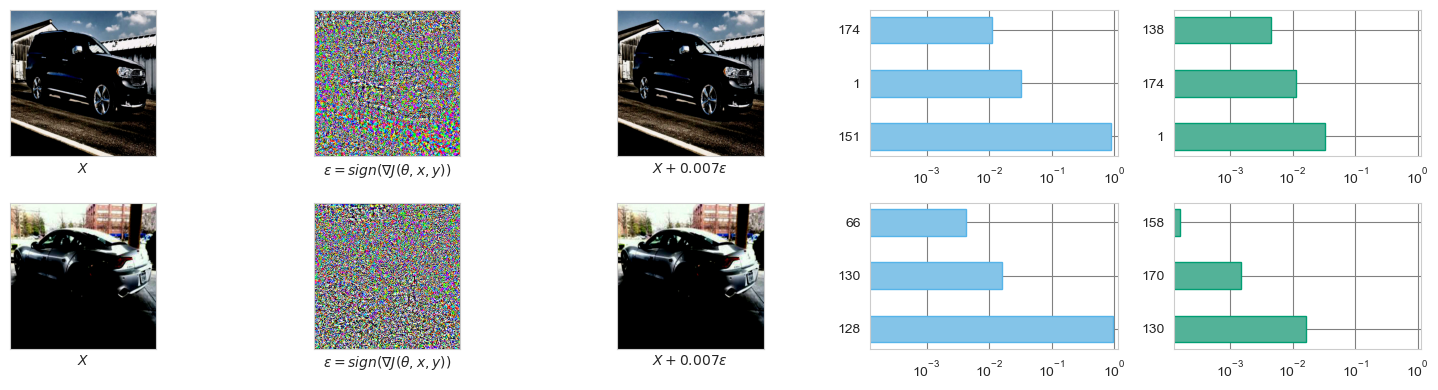

In [64]:
f, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,4))

for i in range(2):
    axs[i,0].imshow(X_plot[i])
    axs[i,0].set_xticks([]); axs[i,0].set_yticks([])
    axs[i,0].set_xlabel(r"$X$")

    axs[i,1].imshow(perturbation_plot[i])
    axs[i,1].set_xticks([]); axs[i,1].set_yticks([])
    axs[i,1].set_xlabel(r"$\epsilon = sign(\nabla J(\theta, x, y))$")

    axs[i,2].imshow(adv_plot[i])
    axs[i,2].set_xticks([]); axs[i,2].set_yticks([])
    axs[i,2].set_xlabel(r"$X + 0.007 \epsilon$")

    axs[i,3].barh([str(i.item()) for i in top_labels[i]], top_dist[i], height=0.5, color="#84c4e8", edgecolor="#56B4E9")
    axs[i,3].set_xlim(min_x_log, max_x_log)
    axs[i,3].set_xscale("log")
    axs[i,3].set_axisbelow(True)
    axs[i,3].yaxis.grid(color='gray', linestyle='-')
    axs[i,3].xaxis.grid(color='gray', linestyle='-')

    axs[i,4].barh([str(i.item()) for i in adv_top_labels[i]], adv_top_dist[i], height=0.5, color="#53b298", edgecolor="#009E73")
    axs[i,4].set_xlim(min_x_log, max_x_log)
    axs[i,4].set_xscale("log")
    axs[i,4].set_axisbelow(True)
    axs[i,4].yaxis.grid(color='gray', linestyle='-')
    axs[i,4].xaxis.grid(color='gray', linestyle='-')

plt.savefig("../experiments/results/r18_pretrained_fre0.png")
plt.savefig('imgs/adversarial_attack.png', dpi=300)
plt.tight_layout()
plt.show()